<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Semi_Supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[KerasCV] Semi-supervised image classification using contrastive pretraining with SimCLR**

***Semi-supervised learning***


Semi-supervised learning is a machine learning paradigm that deals with partially labeled datasets. When applying deep learning in the real world, one usually has to gather a large dataset to make it work well. However, while the cost of labeling scales linearly with the dataset size (labeling each example takes a constant time), model performance only scales sublinearly with it. This means that labeling more and more samples becomes less and less cost-efficient, while gathering unlabeled data is generally cheap, as it is usually readily available in large quantities.
Semi-supervised learning offers to solve this problem by only requiring a partially labeled dataset, and by being label-efficient by utilizing the unlabeled examples for learning as well.
In this example, we will pretrain an encoder with contrastive learning on the STL-10 semi-supervised dataset using no labels at all, and then fine-tune it using only its labeled subset.


**Contrastive learning**


On the highest level, the main idea behind contrastive learning is to learn representations that are invariant to image augmentations in a self-supervised manner. One problem with this objective is that it has a trivial degenerate solution: the case where the representations are constant, and do not depend at all on the input images.
Contrastive learning avoids this trap by modifying the objective in the following way: it pulls representations of augmented versions/views of the same image closer to each other (contracting positives), while simultaneously pushing different images away from each other (contrasting negatives) in representation space.
One such contrastive approach is SimCLR, which essentially identifies the core components needed to optimize this objective, and can achieve high performance by scaling this simple approach.
Another approach is SimSiam (Keras example), whose main difference from SimCLR is that the former does not use any negatives in its loss. Therefore, it does not explicitly prevent the trivial solution, and, instead, avoids it implicitly by architecture design (asymmetric encoding paths using a predictor network and batch normalization (BatchNorm) are applied in the final layers).
For further reading about SimCLR, check out the official Google AI blog post, and for an overview of self-supervised learning across both vision and language check out this blog post.

In [ ]:
pip install keras-cv tensorflow --upgrade

In [ ]:

pip install git+https://github.com/keras-team/keras-cv.git tensorflow --upgrade

In [3]:
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

Using TensorFlow backend


In [4]:
# Dataset hyperparameters
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3
NUM_CLASSES = 10

# Algorithm hyperparameter
UNLABELED_BATCH_SIZE = 1024
LABELED_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
PROJECTION_WIDTH = 128
TEMPERATURE = 0.1

# Stronger augmentations for contrastive
CONTRASTIVE_AUGMENTATION = {
    "crop_area_factor": (0.08, 1.0),
    "aspect_ratio_factor": (3 / 4, 4 / 3),
    "color_jitter_rate": 0.8,
    "brightness_factor": 0.2,
    "contrast_factor": 0.8,
    "saturation_factor": (0.3, 0.7),
    "hue_factor": 0.2,
}

# Weaker ones for supervised training
CLASSIFICATION_AUGMENTATION = {
    "crop_area_factor": (0.8, 1.0),
    "aspect_ratio_factor": (3 / 4, 4 / 3),
    "color_jitter_rate": 0.05,
    "brightness_factor": 0.1,
    "contrast_factor": 0.1,
    "saturation_factor": (0.1, 0.1),
    "hue_factor": 0.2,
}

AUTOTUNE = tf.data.AUTOTUNE

**Dataset**

The dataset has three splits: - Training Unlabelled: This dataset is used to train the encoder in the contrastive setting. - Training Lablelled: This dataset is used to train the baseline encoder (supervised) and also fine tune the pre-trained encoder. - Testing Labelled: This dataset is used to evaluate the models.

In [5]:
def prepare_dataset():
    unlabeled_train_dataset = (tfds.load("stl10", data_dir = "dataset", split = "unlabelled", as_supervised = True)
                                .map(lambda image, _ : image, num_parallel_calls = AUTOTUNE)
                                .shuffle(buffer_size = 2 * UNLABELED_BATCH_SIZE)
                                .batch(UNLABELED_BATCH_SIZE, num_parallel_calls = AUTOTUNE)
                                .prefetch(AUTOTUNE))

    labeled_train_dataset = (tfds.load("stl10", data_dir="dataset", split="train", as_supervised=True)
                             .shuffle(buffer_size=10 * LABELED_BATCH_SIZE)
                             .batch(LABELED_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
                             .prefetch(AUTOTUNE))

    test_dataset = (tfds.load("stl10", data_dir = "dataset", split = "test", as_supervised = True)
                    .batch(TEST_BATCH_SIZE, num_parallel_calls = AUTOTUNE)
                    .prefetch(AUTOTUNE))

    return unlabeled_train_dataset, labeled_train_dataset, test_dataset

In [6]:
unlabeled_train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling dataset/stl10/1.0.0.incompleteH3G2J8/stl10-train.tfrecord*...:   0%|          | 0/5000 [00:00<?, ? e…

Generating test examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling dataset/stl10/1.0.0.incompleteH3G2J8/stl10-test.tfrecord*...:   0%|          | 0/8000 [00:00<?, ? ex…

Generating unlabelled examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling dataset/stl10/1.0.0.incompleteH3G2J8/stl10-unlabelled.tfrecord*...:   0%|          | 0/100000 [00:00…

Dataset stl10 downloaded and prepared to dataset/stl10/1.0.0. Subsequent calls will reuse this data.


In [8]:
for i, j in labeled_train_dataset.take(10):
    print(j)

tf.Tensor(
[0 8 4 9 9 1 3 7 1 2 7 5 7 7 2 1 6 9 4 4 8 6 5 4 6 8 9 4 4 6 1 9 1 0 8 9 1
 7 8 4 1 9 6 6 8 4 1 7 1 5 8 5 7 6 4 1 3 2 2 3 7 7 6 6 7 0 0 7 8 0 5 8 7 7
 4 5 8 7 4 7 7 9 1 5 1 2 8 7 3 1 3 1 5 1 4 6 4 8 2 2 6 1 2 0 9 8 2 6 6 8 3
 9 9 6 1 9 8 9 6 4 0 4 6 5 6 6 6 7], shape=(128,), dtype=int64)
tf.Tensor(
[0 8 9 2 5 9 1 7 6 7 4 0 8 3 6 0 4 7 3 5 0 6 3 8 3 6 4 8 1 7 4 8 3 8 6 7 5
 8 9 2 5 2 6 7 2 6 7 1 2 0 9 0 5 1 6 1 4 8 4 3 9 0 6 8 6 6 9 8 6 2 7 1 4 3
 0 3 2 7 6 3 8 3 9 0 7 2 6 2 5 3 0 2 3 9 8 7 1 3 7 1 7 9 8 1 7 5 9 7 0 6 3
 2 6 0 3 3 4 3 5 1 3 0 2 1 2 0 4 0], shape=(128,), dtype=int64)
tf.Tensor(
[4 7 4 7 1 5 6 5 6 4 2 8 8 9 6 0 8 7 2 4 4 2 6 6 7 7 0 3 1 1 8 0 5 4 3 2 3
 4 6 3 9 7 6 6 7 0 9 5 4 4 8 3 4 7 5 0 5 4 8 1 7 7 9 5 0 9 7 7 8 3 6 7 8 4
 1 1 3 4 8 2 8 5 5 1 8 2 7 3 5 9 4 6 7 5 1 0 4 2 5 2 2 1 2 6 7 2 7 8 0 4 3
 3 9 8 8 2 5 2 5 8 8 4 8 7 2 5 3 1], shape=(128,), dtype=int64)
tf.Tensor(
[0 0 5 1 4 5 8 2 1 3 9 8 5 6 1 3 0 9 7 3 0 9 0 2 3 7 9 1 4 4 7 8 5 0 2 9 5
 2 0 2 7 4 1 0

***Image augmentations***

The two most important image augmentations for contrastive learning are the following:


Cropping: forces the model to encode different parts of the same image similarly.

Color jitter: prevents a trivial color histogram-based solution to the task by distorting color histograms. A principled way to implement that is by affine transformations in color space.

Stronger augmentations are applied for contrastive learning, along with weaker ones for supervised classification to avoid overfitting on the few labeled examples.
We implement the augmentations using the KerasCV library.

In [9]:
def get_augmention(crop_area_factor, aspect_ratio_factor, color_jitter_rate, brightness_factor, contrast_factor, saturation_factor,hue_factor):
    return keras.Sequential([
        keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE,  IMAGE_CHANNELS)),
        keras_cv.layers.Rescaling(1.0/255.0),
        keras_cv.layers.RandomFlip("horizontal"),
        keras_cv.layers.RandomCropAndResize(
            target_size = (IMAGE_SIZE, IMAGE_SIZE),
            crop_area_factor = crop_area_factor,
            aspect_ratio_factor = aspect_ratio_factor),
        keras_cv.layers.RandomApply(
            keras_cv.layers.RandomColorJitter(
                value_range = (0,1),
                brightness_factor = brightness_factor,
                contrast_factor = contrast_factor,
                saturation_factor = saturation_factor,
                hue_factor = hue_factor),
            rate = color_jitter_rate)])

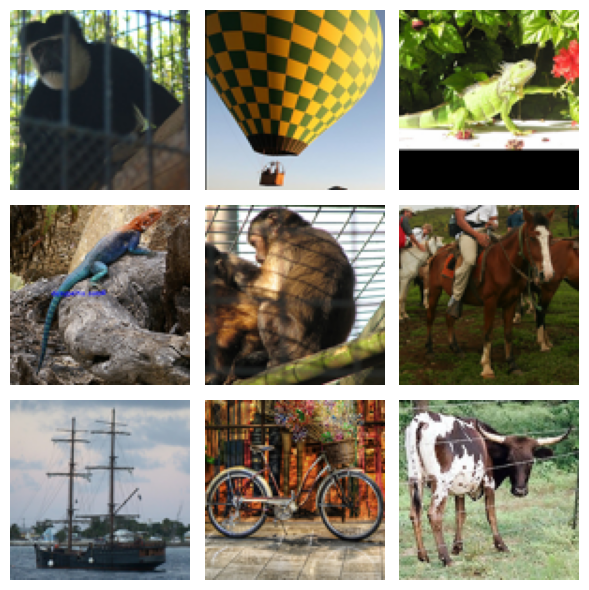

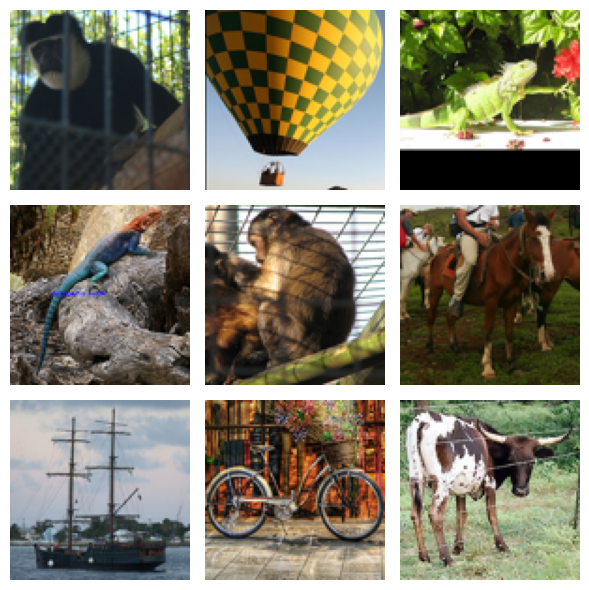

In [10]:
unlabelle_image = next(iter(unlabeled_train_dataset))
keras_cv.visualization.plot_image_gallery(
    images = unlabelle_image,
    value_range = (0, 255),
    rows = 3,
    cols = 3)

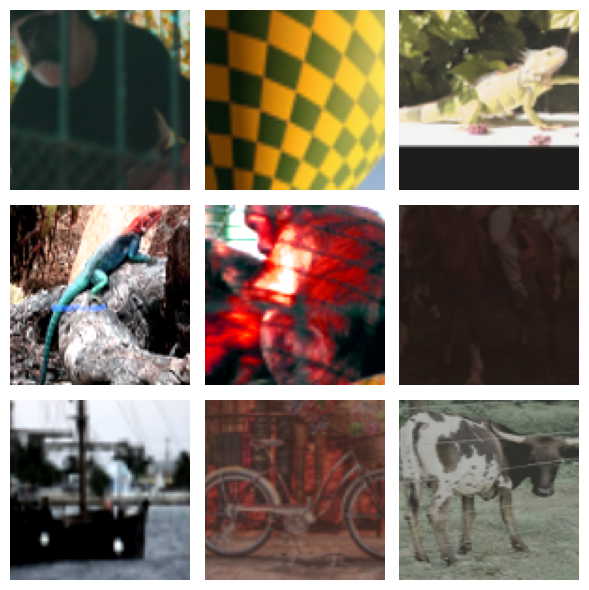

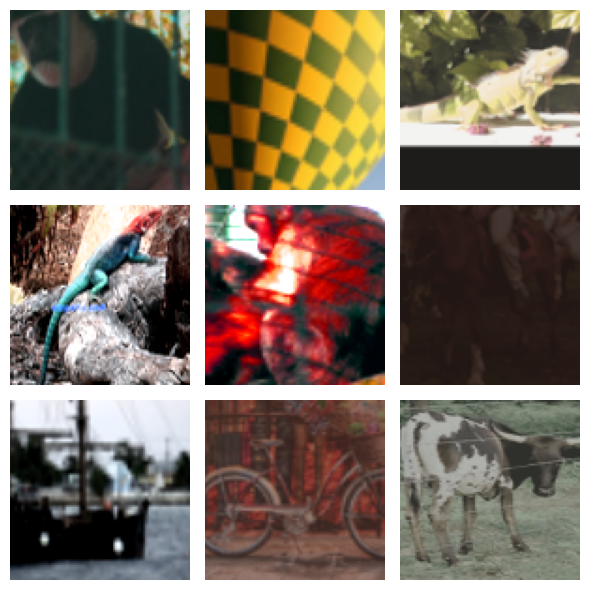

In [11]:
con_augment = get_augmention(**CONTRASTIVE_AUGMENTATION)
aug_img = con_augment(unlabelle_image)
keras_cv.visualization.plot_image_gallery(
    images = aug_img,
    value_range = (0,1),
    rows = 3,
    cols = 3)



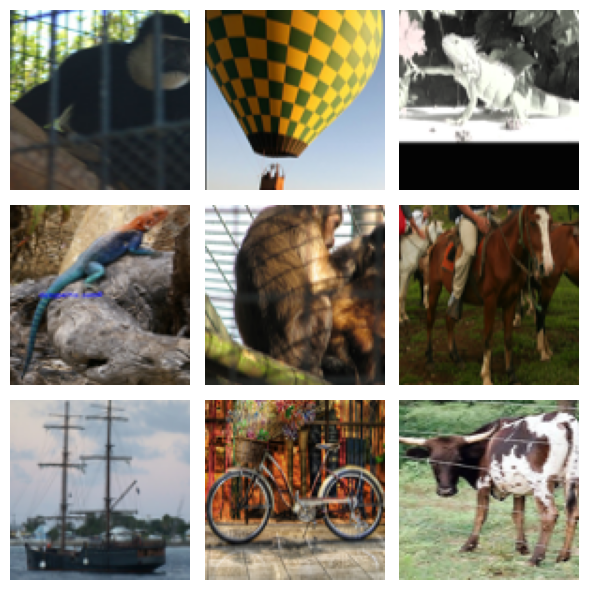

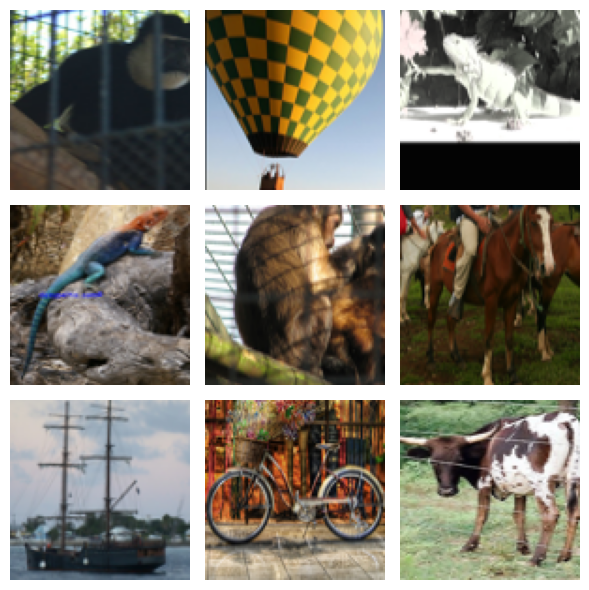

In [12]:
classi_augmenter = get_augmention(**CLASSIFICATION_AUGMENTATION)
aug_img = classi_augmenter(unlabelle_image)
keras_cv.visualization.plot_image_gallery(
    images=aug_img,
    value_range=(0, 1),
    rows=3,
    cols=3,
)

**Encoder architecture**

We use the ResNet18Backbone from the KerasCV library. Try out different backbones and check whether any model trains better in this paradigm. Also try to reason out why that happened.

In [13]:
def get_encoder():
    return keras.Sequential([
        keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),

        keras_cv.models.ResNet18Backbone(include_rescaling = False),

        keras.layers.GlobalAveragePooling2D(name = "avg_pool")
    ], name = "encoder")

In [14]:
base_model = keras.Sequential([
    keras.Input(shape = (IMAGE_SIZE,  IMAGE_SIZE, IMAGE_CHANNELS)),
    get_augmention(**CLASSIFICATION_AUGMENTATION),
    get_encoder(),
    keras.layers.Dense(NUM_CLASSES)
    ])

In [15]:
base_model.compile(optimizer = "adam",
                   loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                   metrics = [keras.metrics.SparseCategoricalAccuracy(name = "acc")])

In [16]:
baseline_history = base_model.fit(
    labeled_train_dataset, epochs=20, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/20


40/40 [==============================] - ETA: 0s - loss: 1.8449 - acc: 0.3442

40/40 [==============================] - 46s 527ms/step - loss: 1.8449 - acc: 0.3442 - val_loss: 6.9977 - val_acc: 0.1000
Epoch 2/20
40/40 [==============================] - 29s 703ms/step - loss: 1.4128 - acc: 0.4768 - val_loss: 4.0578 - val_acc: 0.1591
Epoch 3/20
40/40 [==============================] - 18s 441ms/step - loss: 1.3023 - acc: 0.5218 - val_loss: 4.0133 - val_acc: 0.1000
Epoch 4/20
40/40 [==============================] - 18s 432ms/step - loss: 1.2358 - acc: 0.5450 - val_loss: 3.0805 - val_acc: 0.1427
Epoch 5/20
40/40 [==============================] - 18s 440ms/step - loss: 1.1333 - acc: 0.5852 - val_loss: 3.0522 - val_acc: 0.1506
Epoch 6/20
40/40 [==============================] - 19s 469ms/step - loss: 1.0531 - acc: 0.6168 - val_loss: 2.6755 - val_acc: 0.2311
Epoch 7/20
40/40 [==============================] - 18s 446ms/step - loss: 0.9731 - acc: 0.6430 - val_loss: 3.0830 - val_acc: 0.1678
Epoch 8/20
40/40 [==============================] - 19s 476ms/step - loss: 0.924

***Self-supervised model for contrastive pretraining***


We pretrain an encoder on unlabeled images with a contrastive loss. A nonlinear projection head is attached to the top of the encoder, as it improves the quality of representations of the encoder.


We use the InfoNCE/NT-Xent/N-pairs loss (KerasCV already has this implemented as the SimCLRLoss), which can be interpreted in the following way:


We treat each image in the batch as if it had its own class.

Then, we have two examples (a pair of augmented views) for each "class".

Each view's representation is compared to every possible pair's one (for both augmented versions).

We use the temperature-scaled cosine similarity of compared representations as logits.

Finally, we use categorical cross-entropy as the "classification" loss

We subclass the ContrastiveTrainer from the KerasCV library to build the SimCLRTrainer.

In [ ]:
class SimCLRTrainer(keras_cv.training.ContrastiveTrainer):
    def __init__(self, encoder, augmenter, projector, probe=None, **kwargs):
        super().__init__(
            encoder=encoder,
            augmenter=augmenter,
            projector=projector,
            probe=probe,
            **kwargs,
        )


simclr_model = SimCLRTrainer(
    encoder=get_encoder(),
    augmenter=get_augmenter(**CONTRASTIVE_AUGMENTATION),
    projector=keras.Sequential(
        [
            keras.layers.Dense(PROJECTION_WIDTH, activation="relu"),
            keras.layers.Dense(PROJECTION_WIDTH),
            keras.layers.BatchNormalization(),
        ],
        name="projector",
    ),
)

simclr_model.compile(
    encoder_optimizer=keras.optimizers.Adam(),
    encoder_loss=keras_cv.losses.SimCLRLoss(
        temperature=TEMPERATURE,
    ),
)

simclr_history = simclr_model.fit(
    unlabeled_train_dataset,
    epochs=20,
)

**Supervised finetuning of the pretrained encoder**

We then finetune the encoder on the labeled examples, by attaching a single randomly initalized fully connected classification layer on its top.

In [ ]:
# Supervised finetuning of the pretrained encoder
finetune_model = keras.Sequential(
    [
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
        get_augmenter(**CLASSIFICATION_AUGMENTATION),
        simclr_model.encoder,
        keras.layers.Dense(NUM_CLASSES),
    ],
    name="finetuning_model",
)
finetune_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetune_history = finetune_model.fit(
    labeled_train_dataset, epochs=20, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetune_history.history["val_acc"]) * 100
    )
)

In [ ]:

# The classification accuracies of the baseline and finetuning process:
def plot_training_curves(baseline_history, finetune_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            finetune_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(baseline_history, finetune_history)

# **Improving further**

**Architecture**

The experiment in the original paper demonstrated that increasing the width and depth of the models improves performance at a higher rate than for supervised learning. Also, using a ResNet-50 encoder is quite standard in the literature. However keep in mind, that more powerful models will not only increase training time but will also require more memory and will limit the maximal batch size you can use.
It has been reported that the usage of BatchNorm layers could sometimes degrade performance, as it introduces an intra-batch dependency between samples, which is why I did not have used them in this example. In my experiments however, using BatchNorm, especially in the projection head, improves performance.

**Hyperparameters**


The hyperparameters used in this example have been tuned manually for this task and architecture. Therefore, without changing them, only marginal gains can be expected from further hyperparameter tuning.
However for a different task or model architecture these would need tuning, so here are my notes on the most important ones:
Batch size: since the objective can be interpreted as a classification over a batch of images (loosely speaking), the batch size is actually a more important hyperparameter than usual. The higher, the better.Temperature: the temperature defines the "softness" of the softmax distribution that is used in the cross-entropy loss, and is an important hyperparameter. Lower values generally lead to a higher contrastive accuracy. A recent trick (in ALIGN) is to learn the temperature's value as well (which can be done by defining it as a tf.Variable, and applying gradients on it). Even though this provides a good baseline value, in my experiments the learned temperature was somewhat lower than optimal, as it is optimized with respect to the contrastive loss, which is not a perfect proxy for representation quality.Image augmentation strength: during pretraining stronger augmentations increase the difficulty of the task, however after a point too strong augmentations will degrade performance. During finetuning stronger augmentations reduce overfitting while in my experience too strong augmentations decrease the performance gains from pretraining. The whole data augmentation pipeline can be seen as an important hyperparameter of the algorithm, implementations of other custom image augmentation layers in Keras can be found in this repository.Learning rate schedule: a constant schedule is used here, but it is quite common in the literature to use a cosine decay schedule, which can further improve performance.Optimizer: Adam is used in this example, as it provides good performance with default parameters. SGD with momentum requires more tuning, however it could slightly increase performance.